# Optimal transport theory

## Resources

__Python optimal transport__ library, https://pot.readthedocs.io/en/stable/quickstart.html: 
For an introduction to the subject and documentation on the package.

__Computational optimal transport__, https://arxiv.org/pdf/1803.00567.pdf:
Book containing the theory.

In [1]:
import numpy as np
import matplotlib.pylab as plt
import ot
import ot.plot
from ot.datasets import make_1D_gauss as gauss
import matplotlib as mpl
from IPython.display import clear_output
import time
import sys
import numba
import copy

In [2]:
global_dpi = 120
mpl.rcParams['figure.dpi']= global_dpi
mpl.rc('axes', labelsize=13)

def vis_mat(matrix,color = mpl.cm.nipy_spectral, plot = True, vmin = None, vmax = None,extent = None, ranges = None, rounding = 3):
    fig, ax = plt.subplots()
    if ranges == None:
        img = ax.imshow(matrix, cmap = color, extent=[0,matrix.shape[1],matrix.shape[0],0], vmin = vmin, vmax = vmax)
    else: 
        x_max = max(np.abs(ranges[0]),np.abs(ranges[1]))
        y_max = max(np.abs(ranges[2]),np.abs(ranges[3]))
        x_round = rounding - int(np.log10(x_max)//1)
        y_round = rounding - int(np.log10(y_max)//1)
        img = ax.imshow(matrix,cmap = color, vmin = vmin, vmax = vmax)
        plt.yticks(np.linspace(-0.5,len(matrix)-0.5,10))
        plt.xticks(np.linspace(0.5,len(matrix[0])-0.5,10))
        if x_round > 0 and x_round < 2*rounding:
            x = np.round(np.linspace(ranges[0],ranges[1],10),x_round)
        else: 
            x = np.linspace(ranges[0],ranges[1],10)
            x = [np.format_float_scientific(i,precision = rounding-1) for i in x]
        if y_round > 0 and y_round < 2*rounding:
            y = np.round(np.linspace(ranges[3],ranges[2],10),y_round)
        else:
            y = np.linspace(ranges[3],ranges[2],10)
            y = [np.format_float_scientific(i,precision = rounding-1) for i in y]
        ax.set_xticklabels(x)
        ax.set_yticklabels(y)
        plt.xticks(rotation=-45)
    fig.colorbar(img)
    if plot:
        plt.show()

# Introduction

When we want to compare two vectors of the same length, e.g. $\mathbf{a}$ and $\mathbf{b}$, we usually resort to the $l^2$-norm of the difference:

$$ \Delta = ||\mathbf{a}-\mathbf{b}||_2,$$

also known as the Euclidian distance. Larger $\Delta$ would in this case imply a greater dissimilarity between the vectors. We will now demonstrate the problem with this approach. Let us first plot two normalized Gaussians with the same standard deviation $\sigma$, but different means $\mu$ and compute the $l^2$-norm of the difference between the vectors containing the function evaluations. We properly normalize each of the vectors to represent a discrete probability distribution on $[0,99]$.

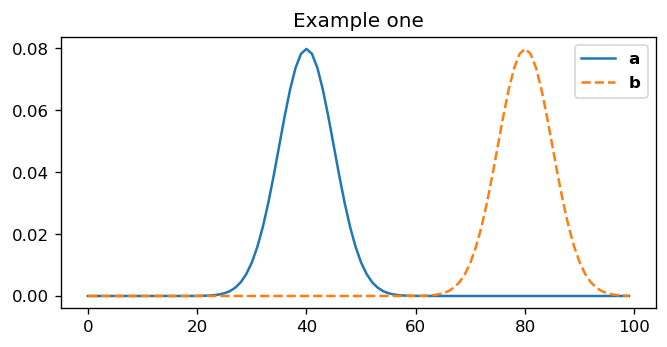

Norm: 0.33592139994857606


In [3]:
na = 100
nb = 100
xa = np.arange(na, dtype=np.float64)
xb = np.arange(nb,dtype = np.float64)
  # number of datapoints i = 1,....,n
# Gaussian distributions
a = gauss(na, m=40, s=5)  # m= mean, s= std
b = gauss(nb, m=80, s=5)
plt.figure(1, figsize=(6.4, 3))
plt.plot(xa, a,  label='$\mathbf{a}$')
plt.plot(xb, b,  label='$\mathbf{b}$',linestyle = '--')
plt.legend()
plt.title('Example one')
plt.show()
print('Norm: ' + str(np.linalg.norm(a-b)) )

Let us now do the same thing, but increase the $\sigma$ of $\mathbf{b}$ from 5 to 10.

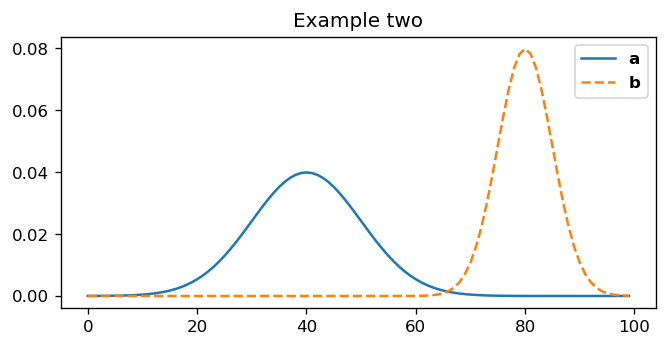

Norm: 0.2907173358353604


In [4]:
na = 100
nb = 100
xa = np.arange(na, dtype=np.float64)
xb = np.arange(nb,dtype = np.float64)
  # number of datapoints i = 1,....,n
# Gaussian distributions
a = gauss(na, m=40, s=10)  # m= mean, s= std
b = gauss(nb, m=80, s=5)
plt.figure(1, figsize=(6.4, 3))
plt.plot(xa, a,  label='$\mathbf{a}$')
plt.plot(xb, b,  label='$\mathbf{b}$',linestyle = '--')
plt.legend()
plt.title('Example two')
plt.show()
print('Norm: ' + str(np.linalg.norm(a-b)) )

According to the $l^2$-norms of both examples, we find that the Gaussians with different $\sigma$ (example two) are more similar as compared to the Gaussians with the same $\sigma$ (example one). This is caused by the overlap between $\mathbf{a}$ and $\mathbf{b}$, due to the increased $\sigma$ of $\mathbf{b}$. Let us now take a look what would happen if we calculate the Wasserstein distance $W_2$ for both examples. Again, a larger value would imply a greater dissimilarity between the vectors. For this we use the __Python Optimal Transport__ (POT) library (https://pot.readthedocs.io/en/stable/#).

In [5]:
na = 100
nb = 100
xa = np.arange(na, dtype=np.float64)
xb = np.arange(nb,dtype = np.float64)

exponent = 2
M = ot.dist(xa.reshape((na, 1)), xb.reshape((nb, 1)))
M = M**(exponent/2)

  # number of datapoints i = 1,....,n
# Gaussian distributions
a = gauss(na, m=40, s=5)  # m= mean, s= std
b = gauss(nb, m=80, s=5)

G0 = ot.emd(a, b, M)
print('Wasserstein distance example one = ' + str(np.sum(M*G0)**(1/exponent)))

a = gauss(na, m=40, s=10)  # m= mean, s= std
b = gauss(nb, m=80, s=5)

G0 = ot.emd(a, b, M)
print('Wasserstein distance example two = ' + str(np.sum(M*G0)**(1/exponent)))

Wasserstein distance example one = 39.99904342400952
Wasserstein distance example two = 40.31231809393457


Now we find that the difference between the two vectors is actually smaller in the first example, as compared to the second example, due to the similar shapes of the evaluated functions. We also know that when comparing two vectors containing the same shapes at different locations, $W_2$ equals the absolute distance between both of the centers of mass. Looking at example one this seems to be the case. Another nice property of the Wasserstein distance is that it allows us unambigouisly compare vectors of two different sizes.

# Wasserstein distance

We first define the Wasserstein distance as

$$W_p(\mathbf{a},\mathbf{b}) = \{\min_{\boldsymbol{\gamma}} \sum_{ij}\gamma_{ij} M_{ij}(p)\}^{1/p},$$

for which $a(\mathbf{x}_i) = a_i$ and $b(\mathbf{y}_i) = b_i$. $W_p$ can be thought of as a measure to compare the resemblance of two shapes. Here we define the cost matrix $\mathbf{M}$ as

$$M_{ij,p} =  ||\mathbf{x}_i-\mathbf{y}_j||_2^p \rightarrow \mathbf{M}_p.$$

This matrix encodes the penalty of moving mass from $\mathbf{x}_i$ to $\mathbf{y}_j$, which in the case of vectors  boils down to $a(x_i) = a_i$ and $b(y_i) = b_i$ (when comparing two matrices this would be $a([x_{i1},x_{i2}]) = a_i$ and $b([y_{i1},y_{i2}]) = b_i$) and

$$M_{ij,p} =  |x_i-y_j|^p \rightarrow \mathbf{M}_p.$$


For $\mathbf{M}$ and $\boldsymbol{\gamma}$ we have

$$\text{dim}(\mathbf{M}) = \text{dim}(\boldsymbol{\gamma}) = \text{dim}(\mathbf{a}) \times \text{dim}(\mathbf{b}), $$

i.e.  $\mathbf{M}_{\text{dim}(\mathbf{a}) \times \text{dim}(\mathbf{b})}$ and $\mathbf{\boldsymbol{\gamma}}_{\text{dim}(\mathbf{a}) \times \text{dim}(\mathbf{b})}$.
For this procedure to work both $\mathbf{a}$ and $\mathbf{b}$ need to abide by

$$\sum_i a_i = 1\text{, } \sum_i b_i = 1 \\ a_i,b_i \geq 0 \text{ } \forall i.$$

In this way $\mathbf{a}$ and $\mathbf{b}$ can be thought of as probability densities.
The following constraints are put on $\boldsymbol{\gamma}:$

$$\sum_{ij} \gamma_{ij} = 1,\\ \gamma_{ij} \geq 0\text{, } \forall i,j \text{ }, \\ \sum_i \gamma_{ij} = b_j,\\ \sum_j \gamma_{ij} = a_i.$$

Now $\boldsymbol{\gamma}$ represents a probability density such that

$$ P(\mathbf{x}_i,\mathbf{y}_j) = \gamma_{ij} \geq 0.$$

In reality $\boldsymbol{\gamma}$ encodes the permutations that need to be carried out to transform one vector into the other, which is then weighted by $\mathbf{M}_p$. 
For the Wasserstein distance the following relations hold:

$$W_p(\mathbf{a},\mathbf{b}) = 0 \text{ iff } \mathbf{a} = \mathbf{b}, \\ W_p(\mathbf{a},\mathbf{b}) = W_p(\mathbf{b},\mathbf{a}), \\
W_p(\mathbf{a},\mathbf{b}) \leq W_p(\mathbf{a},\mathbf{c}) + W_p(\mathbf{c},\mathbf{b})\text{, } \forall \mathbf{a},\mathbf{b},\mathbf{c}$$

for $p > 1$, which makes that $W_p$ classifies as a distance in the space of probability densities. 

In determining $W_p$ the objective is to find the minimizer $\boldsymbol{\gamma}$. For this we apply numerical optimization techniques. Algorithms to obtain $W_p$ scale at best to order $O(n^2)$, where $n$ is the size of the input vectors. To make numerical optimization more feasible for large input data we introduce the addition of an entropic term $\Omega(\boldsymbol{\gamma})$ weighted by constant $\lambda$:

$$W_p^\lambda(\mathbf{a},\mathbf{b}) = \{\min_{\boldsymbol{\gamma}}\sum_{ij}(\gamma_{ij} M_{ij,p}) + \lambda \sum_{ij}\gamma_{ij}\log(\gamma_{ij})\}^{1/p} = \{\min_{\boldsymbol{\gamma}} \sum_{ij}(\gamma_{ij} M_{ij,p}) + \lambda \Omega(\boldsymbol{\gamma})\}^{1/p},$$ 

resulting in

$$ \boldsymbol{\gamma^*}(\lambda) =arg\min_{\boldsymbol{\gamma}}\{ \sum_{ij}(\gamma_{ij} M_{p,ij}) + \lambda \Omega(\boldsymbol{\gamma})\}.$$

This can in turn be optimized using the Sinkhorn algorithm, which we will discuss later in more detail. For $p > 1$ the solution of $\boldsymbol{\gamma}$ (or approximate solution $\boldsymbol{\gamma^*}$) is indepent of chosen $p$, i.e. the solution is always the same for $p > 1$. This is why there is no need to write the exponent anymore, since this results in the same minimizer $\boldsymbol{\gamma^*}$.
Increasing the parameter $\lambda$ results in faster convergence to the solution but also results in a larger error, as compared to $\lambda = 0$. After numerically obtaining the solution for $\boldsymbol{\gamma}$ (or $\boldsymbol{\gamma^*}$) we obtain $W_p$ (or $W_p^\lambda$) by doing 

$$W_p = (\sum_{ij}\gamma_{ij} M_{p,ij})^{1/p} = \text{Tr}(\mathbf{M}^{T}_p \boldsymbol{\gamma})^{1/p},$$

omitting the entropic part.

# Wasserstein distance example

The aim of this example is to compare two Gaussian distribtions ($a(x)$ and $b(y)$) with the same standard deviation, but a different mean, using the Wasserstein distance.

## Generating Gaussians

We start off by generating $n_a =100$ and $n_b = 150$ equally spaced points $\mathbf{x} = (0,2,...,99)^T$ and $\mathbf{y} = (0,2,...,149)^T$ and from these points generate $\mathbf{a}(\mathbf{x})$ and $\mathbf{b}(\mathbf{y})$. The resulting vectors $\mathbf{a}$ and $\mathbf{b}$ are plotted below.

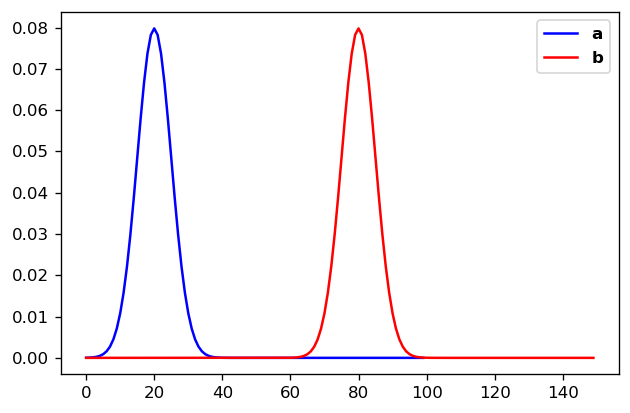

In [6]:
na = 100
nb = 150
xa = np.arange(na, dtype=np.float64)
xb = np.arange(nb,dtype = np.float64)
  # number of datapoints i = 1,....,n
# Gaussian distributions
a = gauss(na, m=20, s=5)  # m= mean, s= std
b = gauss(nb, m=80, s=5)
plt.plot(xa, a, 'b', label='$\mathbf{a}$')
plt.plot(xb, b, 'r', label='$\mathbf{b}$')
plt.legend()
plt.show()

## Generating the cost matrix $\mathbf{M}$

Next, we set up $\mathbf{M}$ by doing 

$$M_{2,ij}=  |x_i-y_j|^2, $$

where we took $p = 2$. This is basically the square of the Euclidian distance between the two points. $\mathbf{M}$ can be thought of as the cost of moving mass from point $x_i$ to $y_j$ and vice versa. The matrix is generated below and the first five entries of the matrix are printed. Next, we do 

$$\mathbf{M} \rightarrow  \frac{\mathbf{M}}{\max_{ij} (M_{ij})}. $$

This is required since large entries in $\mathbf{M}$ can result in numerical difficulties when using the Sinkhorn algorithm. This is however not required when optimizing the exact Wasserstein distance, but we do this now to make the results comparable later on. The exact definition of the Wasserstein distance can be optimized in numerous ways, which scale at best to $O(n^2)$, where $n = \text{dim}(\mathbf{a}) = \text{dim}(\mathbf{b})$.

In [7]:
exponent =2
M = ot.dist(xa.reshape((na, 1)), xb.reshape((nb, 1)))
M = M**(exponent/2)
print(M[:5,:5])
M /= M.max()
#print(M.max())

[[ 0.  1.  4.  9. 16.]
 [ 1.  0.  1.  4.  9.]
 [ 4.  1.  0.  1.  4.]
 [ 9.  4.  1.  0.  1.]
 [16.  9.  4.  1.  0.]]


Next, we plot $\mathbf{a}, \mathbf{b}$ and $\mathbf{M}$.

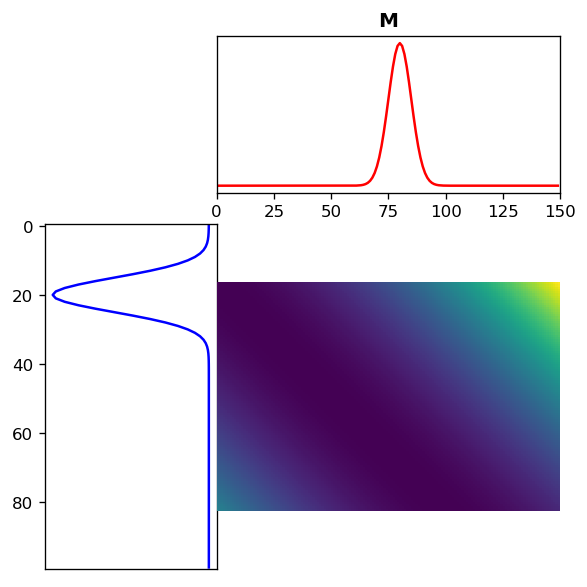

In [8]:
#%% plot distributions and loss matrix
plt.figure(2, figsize=(5, 5))
ot.plot.plot1D_mat(a, b, M, '$\mathbf{M}$')


__Observation:__ The off-diagonal elements become increasingly large.

## Calculating the Wasserstein distance

Finally, the solution for $\boldsymbol{\gamma}$ is numerically obtained and plotted along $\mathbf{a}$ and $\mathbf{b}$. The cost can now be calculated as both

$$W_2 = (\sum_{ij}\gamma_{ij} M_{2,ij})^{1/2} = \text{Tr}( \mathbf{M}^T_2 \boldsymbol{\gamma} )^{1/2}.$$

Wasserstein distance: 0.4026816729385127 (sum of indices)
Wasserstein distance: 0.4026816729385127 (Trace M*γ)


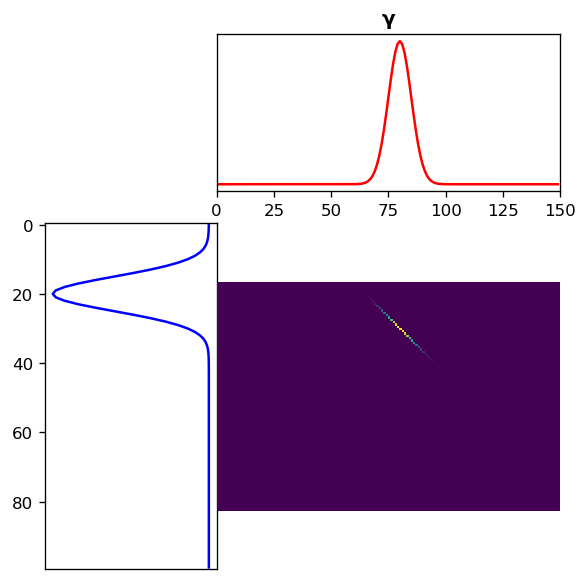

In [10]:
G0 = ot.emd(a, b, M)
plt.figure(3, figsize=(5, 5))
ot.plot.plot1D_mat(a, b, G0, '$\mathbf{\gamma}$')
print('Wasserstein distance: ' + str(np.sum(G0*M)**(1/exponent)) + ' (sum of indices)\nWasserstein distance: ' + str(np.trace(np.dot(M.T,G0))**(1/exponent)) + ' (Trace M*γ)')
exact = np.sum(G0*M)**(1/exponent)
plt.show()

__Observation:__ We observe a sharp band in $\gamma$ where the two Gaussians seem to overlap. We also find that both methods for calculating $W_2$ give the same result.

## Transforming vectors using $\boldsymbol{\gamma}$

As stated earlier $\boldsymbol{\gamma}$ encodes the mass transport needed to transform $\mathbf{a}$ into $\mathbf{b}$ and vice versa. The mass transport from $\mathbf{a}$ to $\mathbf{v}_b$ can be depicted in the following way for $\mathbf{v}_b = (0,0,...,0)^T$ and $\text{dim}(\mathbf{v}_b) = \text{dim}(\mathbf{b})$:

$$ a_i \rightarrow a_i - \gamma_{ij}, \\ v_{b,j} \rightarrow v_{b,j} +  \gamma_{ij}.$$

The same procedure can be followed for mass transport from $\mathbf{b}$ to $\mathbf{v}_a$ ($\mathbf{v}_a = (0,0,...,0)^T$ and $\text{dim}(\mathbf{v}_a) = \text{dim}(\mathbf{a})$), namely

$$ b_j \rightarrow b_j - \gamma_{ij}, \\ v_{a,i} \rightarrow v_{a,i} +  \gamma_{ij}.$$

The mass transport can be summarized as:

$$\mathbf{v}_a \rightarrow \mathbf{a}, \\ \mathbf{v}_b \rightarrow \mathbf{b}, \\ \mathbf{a}\rightarrow (0,0,...,0)^T, \\ \mathbf{b}\rightarrow (0,0,...,0)^T.$$


In [10]:
@numba.njit(parallel = True)
def transform(a,b,gamma):
    a_orig = a.copy()
    b_orig = b.copy()
    a_trans = np.zeros(len(a))
    b_trans = np.zeros(len(b))
    for i in range(gamma.shape[0]):
        for j in range(gamma.shape[1]):
            ### MASS TRANSPORT a->b
            a_orig[i] -= gamma[i,j]
            b_trans[j] += gamma[i,j]
            ### MASS TRANSPORT b->a
            b_orig[j] -= gamma[i,j]
            a_trans[i] += gamma[i,j]
    return a_trans, b_trans, a_orig, b_orig

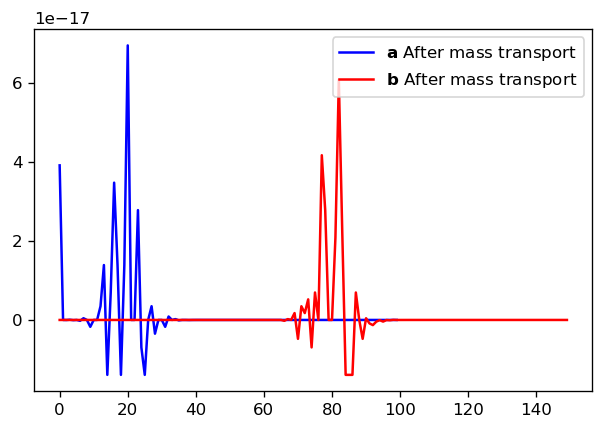

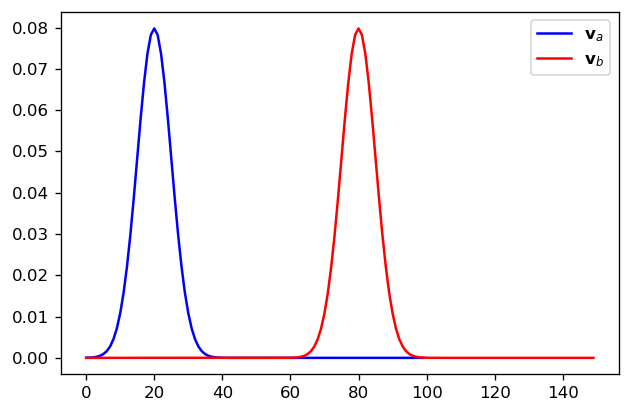

In [11]:
a_trans,b_trans, a_orig, b_orig = transform(a,b,G0)

plt.plot(xa,a_orig, c= 'b')
plt.plot(xb,b_orig,c = 'r')
plt.legend(('$\mathbf{a}$ After mass transport','$\mathbf{b}$ After mass transport'))
plt.show()


plt.plot(xa,a_trans, c= 'b')
plt.plot(xb,b_trans ,c = 'r')
plt.legend(('$\mathbf{v}_a$','$\mathbf{v}_b$'))
plt.show()

__Observation:__ After mass transport the elements of $\mathbf{a}$ and $\mathbf{b}$ are now all very close to zero. $\mathbf{v}_a$ And $\mathbf{v}_b$ are now the same as $\mathbf{a}$ and $\mathbf{b}$, respectively, prior to mass transport.

## Effect of the scaling of $\mathbf{M}$

Next, we investigate the effect of the scaling of $\mathbf{M}$ matrix on the obtained Wasserstein distance.

$$\mathbf{M} \rightarrow  \frac{\mathbf{M}}{c}. $$



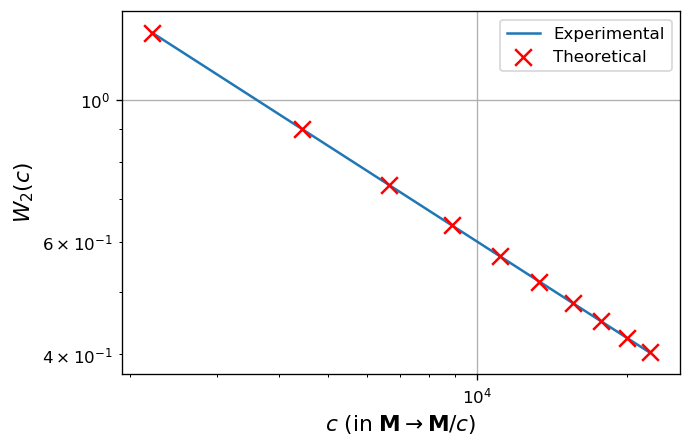

In [11]:
points = 10
M2 = ot.dist(xa.reshape((na, 1)), xb.reshape((nb, 1)))
M2 = M2**(exponent/2)


G0 = ot.emd(a, b, M2)
init = np.sum(G0*(M2))**(1/exponent)
scaling = np.linspace(M2.max()/points,M2.max(),points)
Ws = []
for i in scaling:
    G0 = ot.emd(a, b, M2/i)
    Ws.append(np.sum(G0*(M2/i))**(1/exponent))
plt.plot(scaling,Ws)
plt.xlabel(r'$c$ (in $\mathbf{M} \rightarrow \mathbf{M}/c$)')
plt.ylabel('$W_2(c)$')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.scatter(scaling,init/(scaling**(1/exponent)),c = 'r' ,marker = 'x',zorder =12, s = 100)
plt.legend(('Experimental','Theoretical'))
plt.show()

__Observation:__ $W_p$ scales according to a power law in $c$, since the plot is linear in log-log represantation. We can explicitely show this by doing 

$$W_p(c) = (\sum_{ij}\gamma_{ij} \frac{M_{p,ij}}{c})^{1/p} = \sum_{ij}\gamma_{ij}^{1/p} \frac{M_{1,ij}}{c^{1/p}} =  \frac{\sum_{ij}\gamma_{ij}^{1/p} M_{1,ij}}{c^{1/p}} = \frac{W_p(1)}{c^{1/p}}. $$

## Checking the constraints on $\boldsymbol{\gamma}$

Next, we check if the constraints that we put on $\boldsymbol{\gamma}$, namely 

$$\sum_{ij} \gamma_{ij} = 1,\\ \gamma_{ij} \geq 0\text{ } \forall i,j \text{ }, \\\sum_i \gamma_{ij} = b_j,\\ \sum_j \gamma_{ij} = a_i$$

hold for our solution. This is done below. 

In [13]:
print("First statement (should be 1): " + str(np.sum(G0)))
print('Second statement (should be 0): '+ str(G0.min()))
print('Third statement (should be 0): ' + str(np.linalg.norm(a - np.array([np.sum(i) for i in G0]),2)))
print('Fourth statement (should be 0): ' + str(np.linalg.norm(b - np.array([np.sum(i) for i in G0.T]),2)))

First statement (should be 1): 0.9999999999999999
Second statement (should be 0): 0.0
Third statement (should be 0): 9.803344831292018e-17
Fourth statement (should be 0): 8.567834422004637e-17


__Observation:__ The statements hold up to some error.

## Comparing to the Sinkhorn algorithm

Next, we run the Sinkhorn algorithm for $\lambda = 0.001$ and obtain roughly the same Wasserstein difference , when omitting the entropic part ($\lambda \Omega(\boldsymbol{\gamma}))$. 

It.  |Err         
-------------------
    0|3.464335e-01|
   10|1.801051e-02|
   20|2.201312e-04|
   30|2.688395e-06|
   40|3.283250e-08|
   50|4.009727e-10|
Cost: 0.4032340079418959 (sum of indices)
Cost: 0.4032340079418959 (Trace M*γ)


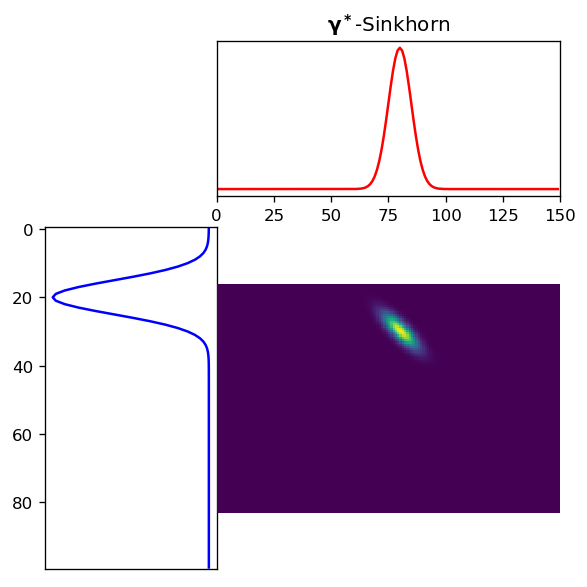

In [12]:
lambd = 0.001
Gs = ot.sinkhorn(a, b, M, lambd, verbose=True)
plt.figure(4, figsize=(5, 5))
ot.plot.plot1D_mat(a, b, Gs, '$\mathbf{\gamma^*}$-Sinkhorn')
print('Cost: ' + str(np.sum(Gs*M)**(1/exponent)) + ' (sum of indices)\nCost: ' + str(np.trace(np.dot(M.T,Gs))**(1/exponent)) + ' (Trace M*γ)')
plt.show()

__Observation__: We find roughly the same $W_2$ value, however the band in $\boldsymbol{\gamma}$ is now less sharp.

## Accuracy of the Sinkhorn algorithm as compared to the exact Wasserstein distance

As a little experiment we can measure the accuracy in obtained Wasserstein distance, by comparing to the solution found for the exact Wasserstein distance, and plotting this against $\lambda$. The result is depicted below. 

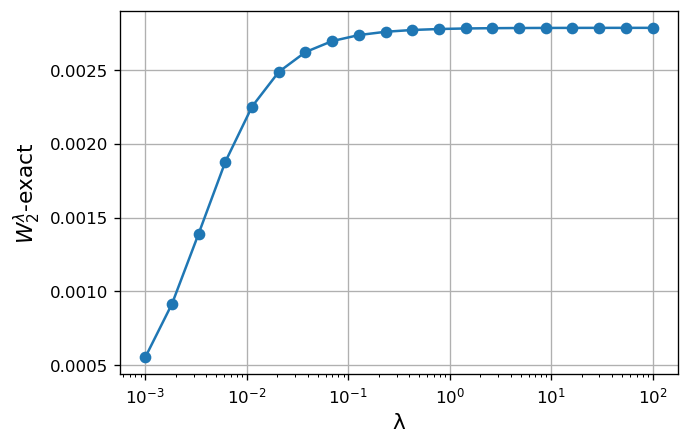

In [15]:
lambds = np.array([10**x for x in np.linspace(-3,2,20)])
Ws = []
for lambd in lambds:
    Ws.append((np.sum(ot.sinkhorn(a, b, M, lambd, verbose=True)*M))**(1/exponent))
    clear_output()
Ws = np.array(Ws)
plt.plot(lambds,Ws-exact, marker = 'o')
plt.grid(True)
#plt.yscale('log')
plt.xscale('log')
plt.ylabel('$W_2^λ$-exact')
plt.xlabel('λ')
plt.show()

__Observation:__ We see here that the difference between the exact solution and the approximate solution is always positive. This is because the Sinkhorn-algorithm approaches the exact solution from above. The solution seems to approach a plateau for increasing $\lambda$.

# Implementation of the Sinkhorn algorithm

## Normalizing custom functions

After obtaining the vectors of function evaluations $\mathbf{a}$ and $\mathbf{b}$ we do the following when atleast one of the entries is smaller than zero:

$$\mathbf{v} \rightarrow \mathbf{v}-\text{min}_i \{v_i \}. $$

This shifts the vector upwards and retains its shape.  Regardless, we add a small offset ($\mathbf{v} \rightarrow \mathbf{v}+0.001*\text{max}_i \{v_i \}$) to each input vector before normalization to prevent $\mathbf{a}$ and $\mathbf{b}$ from containing any zeros. The latter is not a mathematical constraint, but comes from the way the Sinkhorn algorithm is implement in the POT library. As we will see later, this step is not needed when optimizing the exact $W_2$ or using our own implementation of the Sinkhorn algorithm. Finally, The normalization procedure entails

$$v_i\rightarrow\frac{v_i}{\sum_i v_i}. $$

This entire procedure is needed to satisfy the earlier mentioned constraints.

In [14]:
def normalized_function(x,function,params,threshold = 0.0001, offset = True,offset1= True):
    array = function(x,params)
    if offset:
        if array.min() < 0:
            array -= array.min() ### To counter negative functions
    if offset1:
        array += array.max()*threshold
    return array/np.sum(array) 

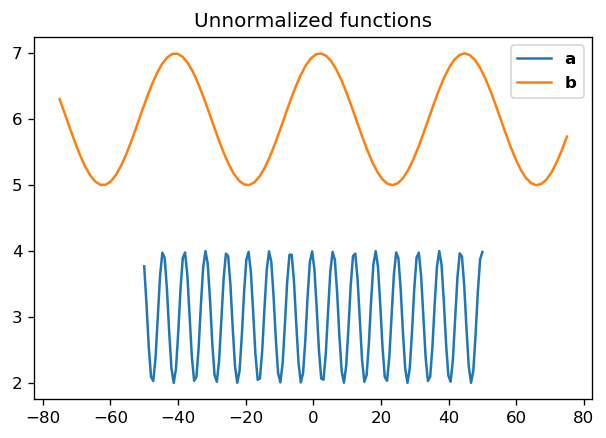

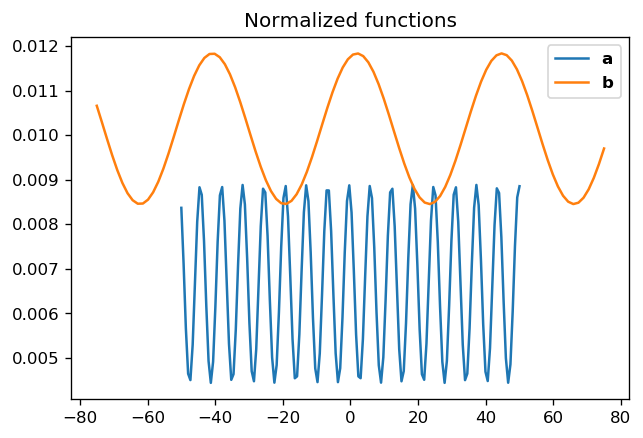

a:
Surface before normalization: 450.19337127754994
Surface after normalization: 1.0000000000000002

b:
Surface before normalization: 591.442411111594
Surface after normalization: 0.9999999999999999


In [15]:
def funct(x,params):
    return np.sin(params[0]*x+params[1]) + params[2]

   
xa = np.linspace(-50,50,150)
xb = np.linspace(-75,75,100)
params_a = [1,2,3]
params_b = [4,5,6]

vec_a = funct(xa,params_a)
vec_b = funct(xb,params_b)

plt.plot(xa,vec_a,label = '$\mathbf{a}$')
plt.plot(xb,vec_b,label = '$\mathbf{b}$')
plt.legend()
plt.title('Unnormalized functions')
plt.show()

nvec_a = normalized_function(xa,funct,params_a)
nvec_b = normalized_function(xb,funct,params_b)

plt.plot(xa,nvec_a,label = '$\mathbf{a}$')
plt.plot(xb,nvec_b,label = '$\mathbf{b}$')
plt.legend()
plt.title('Normalized functions')
plt.show()


print('a:\nSurface before normalization: ' + str(np.sum(vec_a))+ '\nSurface after normalization: ' + str(np.sum(nvec_a)))
print('\nb:\nSurface before normalization: ' + str(np.sum(vec_b))+ '\nSurface after normalization: ' + str(np.sum(nvec_b)))

__Observation:__ The functions are now properly normalized.

## Cost matrix

As stated multiple times before, the cost matrix $\mathbf{M}_p$ is given by

$$M_{ij,p} =  |x_i-y_j|^p \rightarrow \mathbf{M}_p.$$ 

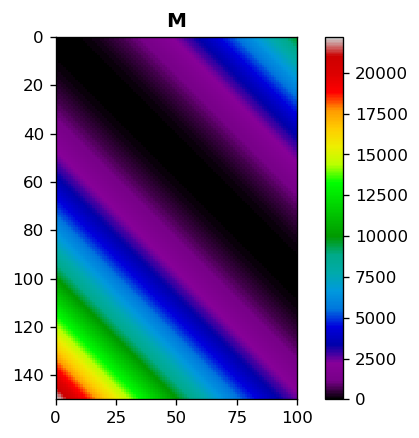

[[0.0000e+00 1.0000e+00 4.0000e+00 ... 9.4090e+03 9.6040e+03 9.8010e+03]
 [1.0000e+00 0.0000e+00 1.0000e+00 ... 9.2160e+03 9.4090e+03 9.6040e+03]
 [4.0000e+00 1.0000e+00 0.0000e+00 ... 9.0250e+03 9.2160e+03 9.4090e+03]
 ...
 [2.1609e+04 2.1316e+04 2.1025e+04 ... 2.5000e+03 2.4010e+03 2.3040e+03]
 [2.1904e+04 2.1609e+04 2.1316e+04 ... 2.6010e+03 2.5000e+03 2.4010e+03]
 [2.2201e+04 2.1904e+04 2.1609e+04 ... 2.7040e+03 2.6010e+03 2.5000e+03]]


In [16]:
def cost_matrix(vec_a,vec_b,exponent = 2):
    xa = np.arange(len(vec_a), dtype=np.float64)
    xb = np.arange(len(vec_b), dtype=np.float64)  
    zeros = np.zeros((len(vec_a),len(vec_b)))
    for i in range(len(vec_a)):
        zeros[i,:] = np.abs(xb-xa[i])**exponent
    return zeros

exponent = 2
M = cost_matrix(nvec_a,nvec_b,exponent = exponent)
vis_mat(M,plot = False)
plt.title('$\mathbf{M}$')
plt.show()
print(M)
M = M/M.max() #To prevent numerical issues

## Algorithm

As stated earlier, optimizing the exact form of the Wasserstein distance scales with $O(n^2)$. Making use of the Sinkhorn algorithm we reduce this $O(\frac{n}{\lambda^2})$. We start off with

$$W_p^\lambda(\mathbf{a},\mathbf{b}) = \{\min_{\boldsymbol{\gamma}} \sum_{ij}(\gamma_{ij} M_{ij,p}) + \lambda \sum_{ij}\gamma_{ij}\log(\gamma_{ij})\}^{1/p},$$ 

resulting in 

$$ \boldsymbol{\gamma^*}(\lambda) =arg\min_{\boldsymbol{\gamma}}\{ \sum_{ij}(\gamma_{ij} M_{ij,p}) + \lambda \sum_{ij}\gamma_{ij}\log(\boldsymbol{\gamma}_{ij})\}.$$

To obtain $\boldsymbol{\gamma^*}$ we take

$$\frac{\partial [ \sum_{ij}(\gamma_{ij} M_{ij,p}) + \lambda \sum_{ij}\gamma_{ij}\log(\gamma_{ij}) ]}{\partial \gamma_{ij}} = M_{ij,p} + \lambda \log{\gamma_{ij}} + \lambda = 0. $$ 

Solving this equation will result in the global minimum, since for $p > 1$, $\sum_{ij}(\gamma_{ij} M_{ij,p}) + \lambda \sum_{ij}\gamma_{ij}\log(\gamma_{ij})$ is strictly convex in the space of probability amplitudes. This means that

$$
\frac{\partial^2 [ \sum_{ij}(\gamma_{ij} M_{ij,p}) + \lambda \sum_{ij}\gamma_{ij}\log(\gamma_{ij}) ]}{\partial \gamma_{ij}^2} = \frac{\lambda}{\gamma_{ij}} > 0, $$

for $\boldsymbol{\gamma}$ representing a probability density.
The solution is now

$$
\gamma_{ij}^* = \text{exp}(\frac{-M_{ij,p}-\lambda}{\lambda}) \rightarrow \boldsymbol{\gamma^*} = \text{exp}(\frac{-\mathbf{M}_p-\lambda}{\lambda}),
$$

where the exponential part resembles the Gibbs kernel as used in statistical mechanics. $\lambda$ Can be thought of as a temperature parameter similar to $k_b T$. Making $\lambda$ larger increasingly desensitizes the system to unoptimal permutations in $\boldsymbol{\gamma}$.
We need to keep in mind the constraints that were placed on $\boldsymbol{\gamma}$, namely

$$\sum_{ij} \gamma_{ij} = 1,\\ \gamma_{ij} \geq 0\text{ } \forall i,j \text{ }, \\ \sum_i \gamma_{ij} = b_j,\\ \sum_j \gamma_{ij} = a_i.$$

To make the notation more simple we briefly change to integral notation. We assume $\gamma^*(x,y)$ has the following form

$$\gamma^*(x,y) = f(x)g(y)\text{exp}(\frac{-M_p(x,y)-\lambda}{\lambda}) = f(x)g(y)K(x,y).$$

Now, we can rewrite the constraints as

$$\int \gamma^*(x,y)dy = a(x), \\ \int \gamma^*(x,y)dx = b(y). $$

Note here that the first two constrains are now also satisfied, because of the constraints we placed on $\mathbf{a}$ and $\mathbf{b}$:

$$\sum_i a_i = 1\text{, } \sum_i b_i = 1, \\ a_i,b_i \geq 0 \text{ } \forall i.$$ 

Now we write

$$g(y) = \frac{b(y)}{\int f(x) K(x,y) dx}, \\ f(x) = \frac{a(x)}{\int g(y) K(x,y) dy}, $$

which can be transformed into an iterative scheme

$$ g^{n+1}(y) = \frac{b(y)}{\int f^{n}(x) K(x,y) dx}, \\ f^{n+1}(x) = \frac{a(x)}{\int g^{n+1}(y) K(x,y) dy}. $$ 

When going back to the matrix/vector notation we can now write the complete algorithm in the following way:

- Initialization: 

$$\mathbf{g}^0 = (1,1,...,1)^T\text{, where }  \text{dim}(\mathbf{g}) = \text{dim}(\mathbf{b})\\ \mathbf{f}^0 = \mathbf{a}^0$$ 

$$\gamma^{*0}_{ij} = f^0_i K_{ij} g^0_{j} \leftrightarrow \boldsymbol{\gamma}^{\mathbf{*}0} = \text{diag}(\mathbf{f}^0)\mathbf{K}\text{diag}(\mathbf{g}^0)$$

$$ \textbf{iterations} = 0 $$

- While $\textbf{iterations}$ < $\textbf{max-iterations}$ and $||\mathbf{g}\odot(\mathbf{K}^T\mathbf{f})-\mathbf{b}||_2$ > $\textbf{threshold}$:

$$ g^{n+1}_i = \frac{b_i}{(\mathbf{K}^T\mathbf{f}^{n})_i} \\ f^{n+1}_i = \frac{a_i}{(\mathbf{K}\mathbf{g}^{n+1})_i} $$
$$\gamma^{*n+1}_{ij} = f^{n+1}_i K_{ij} g^{n+1}_{j} \leftrightarrow \boldsymbol{\gamma}^{\mathbf{*}n+1} = \text{diag}(\mathbf{f}^{n+1})\mathbf{K}\text{diag}(\mathbf{g}^{n+1})$$
$$\textbf{iterations} \rightarrow \textbf{iterations} + 1, $$

where $\odot$ represents the Hadamard product. One should be careful when changing the order of updating $\mathbf{g}$ and $\mathbf{f}$, due to how the convergence condition is defined.

In [17]:
@numba.njit(parallel = True)
def Sinkhorn(a,b,M,lambd = 1e-3,maxiters = 10000, threshold = 10e-5,err_check = 10):
    f = a.copy()
    g = np.ones(len(b))
    K = np.exp((-M-lambd)/lambd)
    iters = maxiters
    err_log = 0
    errors = np.zeros(maxiters)
    sign = 1
    convergence = True
    ######
    #####
    #### Initialize Gamma
    gamma = np.zeros((len(a),len(b)))
    #gamma = np.dot(np.dot(np.diag(f),K),np.diag(g))
    for i in range(len(a)):
        for j in range(len(b)):
            gamma[i,j] = f[i]*g[j]*K[i,j]
    ####
    while sign*iters > 0: ### sign construct to avoid having two conditions in the while loop (unsupported by numba)
        g = b/(np.dot(K.T,f))
        f = a/(np.dot(K,g))
        #gamma = np.dot(np.dot(np.diag(f),K),np.diag(g))
        for i in range(len(a)):
            for j in range(len(b)):
                gamma[i,j] = f[i]*g[j]*K[i,j]    
        ####################
        #####################
        diff = maxiters-iters
        if (diff/err_check-(diff)//err_check) == 0:
            error = np.linalg.norm(g*np.dot(K.T,f)-b,2)
            errors[err_log] = error
            sign = np.sign(error-threshold) ## Part of the sign construct 
            err_log += 1
        iters -= 1
    if iters == 0:
        convergence = False
        print('Warning: Max iterations exceeded')
    return gamma, np.sum(gamma*M), errors[:err_log], convergence
    

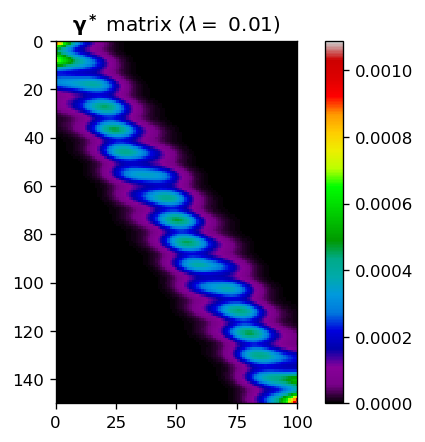

Wasserstein distance: 0.20806867066849172
Wasserstein distance (POT): 0.2080686706654047


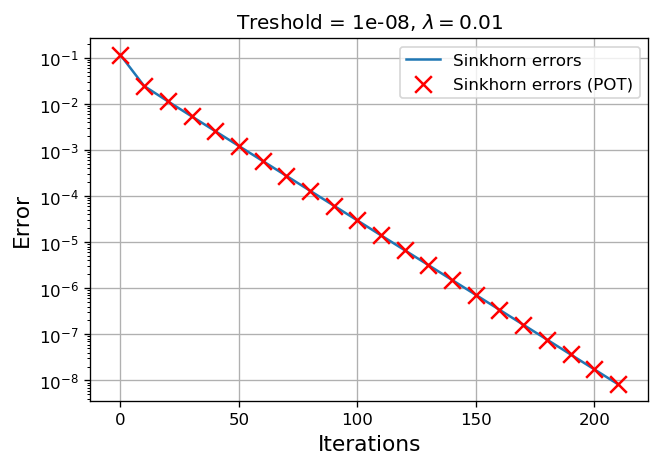

In [19]:
lambd = 10**-(2)
threshold = 1e-8
maxiters = 10000
err_check = 10
Gs, log =  ot.sinkhorn(nvec_a, nvec_b, M, lambd, verbose=False, numItermax=maxiters, stopThr=threshold, log = True)
sinkhorn_errors = log['err']
G, WM,errors,convergence  = Sinkhorn(nvec_a,nvec_b,M,lambd,threshold = threshold,maxiters = maxiters,err_check = err_check)
vis_mat(G, plot = False)
plt.title('$\mathbf{\gamma^*}$ matrix ($\lambda =$ ' + str(lambd) + '$)$')
plt.show()
print('Wasserstein distance: ' + str(WM**(1/exponent)) + '\nWasserstein distance (POT): '+ str(np.sum(Gs*M)**(1/exponent)))
plt.plot(np.arange(len(errors))*err_check,errors)
plt.scatter(np.arange(len(sinkhorn_errors))*err_check,sinkhorn_errors,c = 'r' ,marker = 'x',zorder =12, s = 100)
plt.legend(('Sinkhorn errors','Sinkhorn errors (POT)'))
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.title('Treshold = ' + str(threshold) + ', $\lambda = $' + str(lambd))
plt.grid(True)
plt.yscale('log')
plt.show()

__Observation:__ Both the error and the final result of our own implementation is consistent with the POT library implementation. The small difference in $W_2^\lambda$ is likely caused by the difference in the way $\mathbf{g}$ and $\mathbf{f}$ are initialized or by numerical errors due to the difference in implementation (https://github.com/rflamary/POT/blob/master/ot/bregman.py - sinkhorn_knopp function).

# Some functions

In [21]:
def evaluator(a,b,M,lambd = None,maxiters = None,threshold =None,funct = None,repeat = 10, oT = False,exponent = 2, confidence_interval = 1.96,emd = False):
    cache = []
    for i in range(repeat):
        convergence = None
        if not emd:
            if oT:
                start = time.time()
                G = funct(nvec_a, nvec_b, M, lambd, verbose=False, numItermax=maxiters, stopThr=threshold)
                end = time.time()-start
                cache.append(end)
            else:
                start = time.time()
                data  = funct(a,b,M,lambd = lambd,maxiters = maxiters, threshold = threshold)
                G = data[0]
                convergence = data[3]
                end = time.time()-start
                cache.append(end)
        else:
            start = time.time()
            G = ot.emd(a,b,M)
            end = time.time()-start
            cache.append(end)
    if convergence == None:   
        return np.average(cache),confidence_interval*np.std(cache)/np.sqrt(len(cache)),np.sum(G*M)**(1/exponent)
    else:
        return np.average(cache),confidence_interval*np.std(cache)/np.sqrt(len(cache)),np.sum(G*M)**(1/exponent), convergence
    
def Wasserstein_distance(gamma,M,exponent = 2):
    return np.sum(gamma*M)**(1/exponent)

def Sinkhorn_no_numba(a,b,M,lambd = 1e-3,maxiters = 10000, threshold = 10e-5,err_check = 10):
    f = a.copy()
    g = np.ones(len(b))
    K = np.exp((-M-lambd)/lambd)
    iters = maxiters
    err_log = 0
    errors = np.zeros(maxiters)
    sign = 1
    convergence = True
    ######
    #####
    #### Initialize Gamma
    gamma = np.zeros((len(a),len(b)))
    #gamma = np.dot(np.dot(np.diag(f),K),np.diag(g))
    for i in range(len(a)):
        for j in range(len(b)):
            gamma[i,j] = f[i]*g[j]*K[i,j]
    ####
    while sign*iters > 0: ### sign construct to avoid having two conditions in the while loop (unsupported by numba)
        g = b/(np.dot(K.T,f))
        f = a/(np.dot(K,g))
        #gamma = np.dot(np.dot(np.diag(f),K),np.diag(g))
        for i in range(len(a)):
            for j in range(len(b)):
                gamma[i,j] = f[i]*g[j]*K[i,j]    
        ####################
        #####################
        diff = maxiters-iters
        if (diff/err_check-(diff)//err_check) == 0:
            error = np.linalg.norm(g*np.dot(K.T,f)-b,2)
            errors[err_log] = error
            sign = np.sign(error-threshold) ## Part of the sign construct 
            err_log += 1
        iters -= 1
    if iters == 0:
        convergence = False
        print('Warning: Max iterations exceeded')
    return gamma, np.sum(gamma*M), errors[:err_log], convergence

# Some final experiments

## Shape of the functions we will use for carrying out the experiments

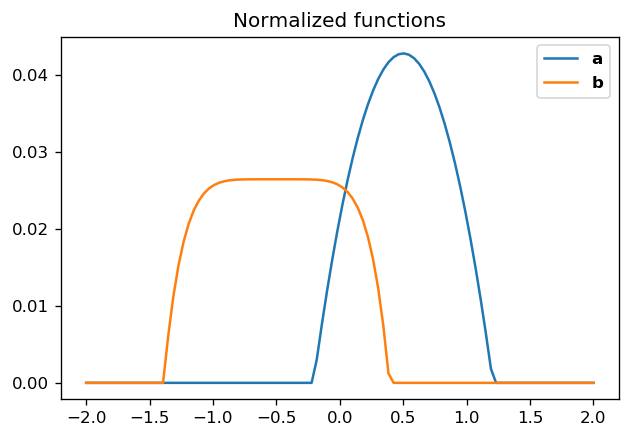

In [22]:
def funct2(x, params):
    array = params[2]*(x+params[0])**params[1] + params[3]
    return np.array([max(0,i) for i in array])  


params_a = [-0.5,2,-1,0.5]
params_b = [0.5,6,-1,0.5]

xa = np.linspace(-2,2,100)
xb = np.linspace(-2,2,100)

nvec_a = normalized_function(xa,funct2,params_a)
nvec_b = normalized_function(xb,funct2,params_b)
plt.plot(xa,nvec_a,label = '$\mathbf{a}$')
plt.plot(xb,nvec_b,label = '$\mathbf{b}$')
plt.legend()
plt.title('Normalized functions')
plt.show()

## Speed: Numba vs pure python loops

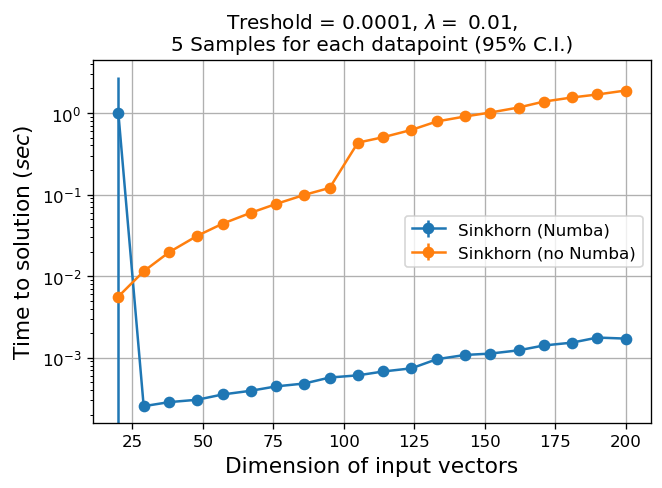

In [23]:
params_a = [-0.5,2,-1,0.5]
params_b = [0.5,6,-1,0.5]
lambd = 1e-2
threshold = 1e-4
maxiters = 10000
exponent = 2
dims = np.linspace(20,200,20)
dims = [int(dim) for dim in dims]
repeat = 5
Ws = []
errors = []
times = []

for dim in dims:
    #############
    cache = []
    cache2 = []
    cache3 = []
    xa = np.linspace(-2,2,dim)
    xb = np.linspace(-2,2,dim)
    nvec_a = normalized_function(xa,funct2,params_a)
    nvec_b = normalized_function(xb,funct2,params_b)
    M = cost_matrix(nvec_a,nvec_b, exponent = exponent)
    M /= M.max()
    ##################
    A,E,W,convergence = evaluator(nvec_a,nvec_b,M,lambd,oT = False,funct = Sinkhorn,threshold= threshold,maxiters = maxiters, repeat = repeat, exponent = exponent)
    cache.append(A)
    cache2.append(E)
    cache3.append(W)
    ################## Running the calculations
    A,E,W,convergence = evaluator(nvec_a,nvec_b,M,lambd,oT = False,funct = Sinkhorn_no_numba,threshold= threshold,maxiters = maxiters, repeat = repeat, exponent = exponent)
    cache.append(A)
    cache2.append(E)
    cache3.append(W)
    #########################
    times.append(cache)
    errors.append(cache2)
    Ws.append(cache3)
    
    if not convergence:
        sys.exit('No convergence at dimension ' + str(dim))
Ws = np.array(Ws).T

#### plot times
times = np.array(times).T
errors = np.array(errors).T
for i in range(len(times)):
    plt.errorbar(dims,times[i],marker = 'o',yerr = errors[i])
plt.legend(('Sinkhorn (Numba)','Sinkhorn (no Numba)'))
plt.title('Treshold = ' + str(threshold) + ', $\lambda =$ ' + str(lambd) + ',\n' + str(repeat) + ' Samples for each datapoint (95% C.I.)' )
plt.grid(True)
plt.xlabel('Dimension of input vectors')
plt.ylabel('Time to solution ($sec$)')
plt.yscale('log')
plt.show()


__Observation:__ Numba massively outperforms the for loops written in pure python.

## Speed: Numba vs python library vs exact Wasserstein distance

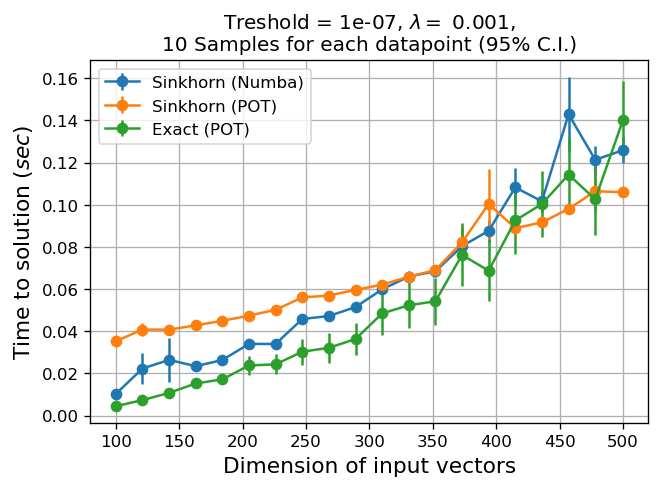

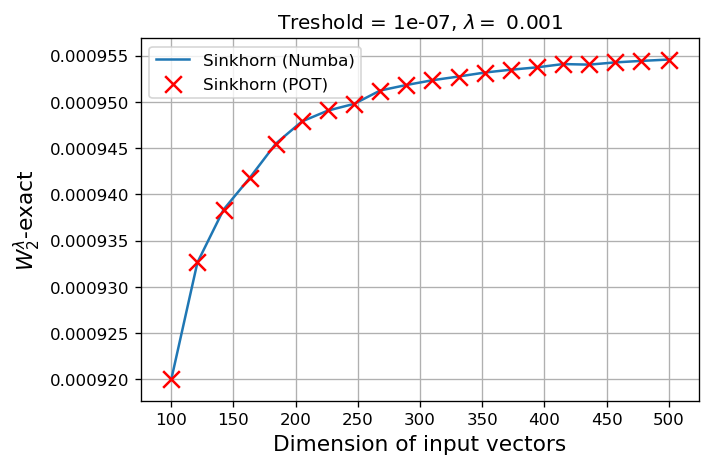

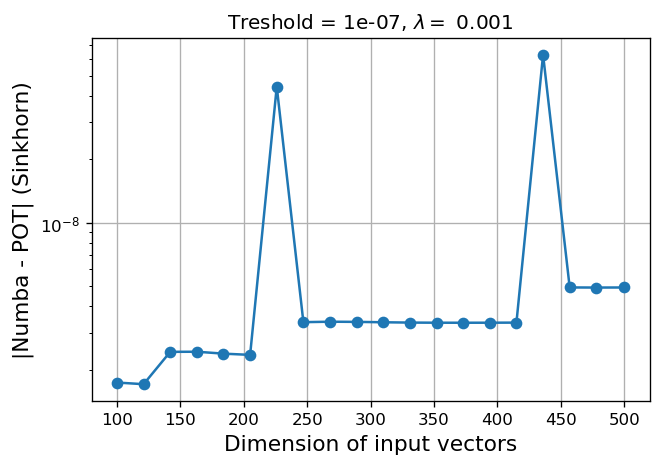

In [24]:
params_a = [-0.5,2,-1,0.5]
params_b = [0.5,6,-1,0.5]
lambd = 1e-3
threshold = 1e-7
maxiters = 10000
exponent = 2
dims = np.linspace(100,500,20)
dims = [int(dim) for dim in dims]
repeat = 10
Ws = []
errors = []
times = []
err_check = 10
for dim in dims:
    cache = []
    cache2 = []
    cache3 = []
    #######
    xa = np.linspace(-2,2,dim)
    xb = np.linspace(-2,2,dim)
    nvec_a = normalized_function(xa,funct2,params_a)
    nvec_b = normalized_function(xb,funct2,params_b)
    M = cost_matrix(nvec_a,nvec_b,  exponent = exponent)
    M /= M.max()
    ############
    
    ############## Running the calculations
    A,E,W,convergence = evaluator(nvec_a,nvec_b,M,lambd,oT = False,funct = Sinkhorn,threshold= threshold,maxiters = maxiters, repeat = repeat, exponent = exponent)
    cache.append(A)
    cache2.append(E)
    cache3.append(W)
    ################## Running the calculations
    A,E,W = evaluator(nvec_a,nvec_b,M,lambd,oT = True,funct = ot.sinkhorn,threshold= threshold,maxiters = maxiters, repeat = repeat, exponent = exponent)
    cache.append(A)
    cache2.append(E)
    cache3.append(W)
    #######################
    A,E,W = evaluator(nvec_a,nvec_b,M,emd = True, repeat = repeat, exponent = exponent)
    cache.append(A)
    cache2.append(E)
    cache3.append(W)
    
    times.append(cache)
    errors.append(cache2)
    Ws.append(cache3)
    
    if not convergence:
        sys.exit('No convergence at dimension ' + str(dim))
Ws = np.array(Ws).T

#### plot times
times = np.array(times).T
errors = np.array(errors).T
for i in range(len(times)):
    plt.errorbar(dims,times[i],marker = 'o',yerr = errors[i])
    
plt.legend(('Sinkhorn (Numba)','Sinkhorn (POT)','Exact (POT)'))
plt.title('Treshold = ' + str(threshold) + ', $\lambda =$ ' + str(lambd) + ',\n' + str(repeat) + ' Samples for each datapoint (95% C.I.)' )
plt.grid(True)
plt.xlabel('Dimension of input vectors')
plt.ylabel('Time to solution $(sec)$')
plt.show()



plt.plot(dims,Ws[0] - Ws[-1])
plt.scatter(dims,Ws[1] - Ws[-1],c = 'r' ,marker = 'x',zorder =12, s = 100)
    
plt.legend(('Sinkhorn (Numba)','Sinkhorn (POT)'))
plt.title('Treshold = ' + str(threshold) + ', $\lambda =$ ' + str(lambd))
plt.grid(True)
plt.xlabel('Dimension of input vectors')
plt.ylabel('$W_2^\lambda$-exact')
plt.show()

plt.plot(dims,np.abs(Ws[0] - Ws[1]), marker = 'o')
    
plt.title('Treshold = ' + str(threshold) + ', $\lambda =$ ' + str(lambd))
plt.grid(True)
plt.xlabel('Dimension of input vectors')
plt.ylabel('|Numba - POT| (Sinkhorn)')
plt.yscale('log')
plt.show()

__Observation:__ We see that the Sinkhorn function imported from POT library performs the best when the dimensions of both input vectors become large. The results are in accordance with the scaling of the algorithms. The small differences in obtained $W_2^\lambda$ between our own implementation and the POT library are likely to be caused by the difference in implementation. 

## $\lambda$ And execution time

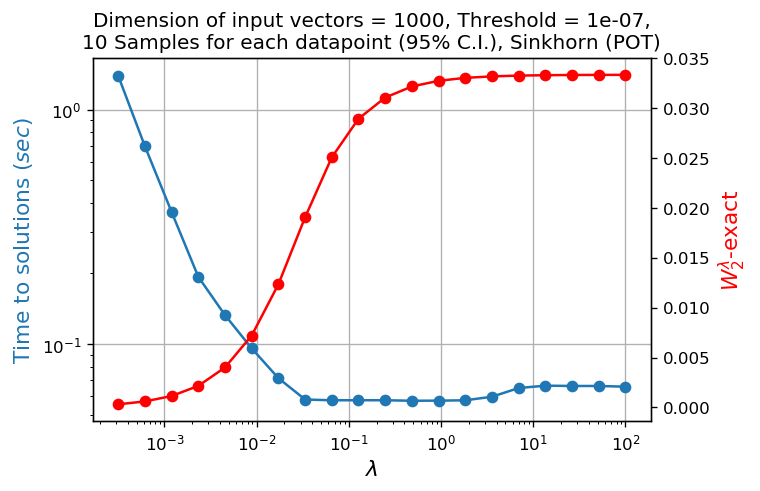

In [25]:
params_a = [-0.5,2,-1,0.5]
params_b = [0.5,6,-1,0.5]
dim = 1000
exponent = 2
threshold = 1e-7
xa = np.linspace(-2,2,dim)
xb = np.linspace(-2,2,dim)
nvec_a = normalized_function(xa,funct2,params_a)
nvec_b = normalized_function(xb,funct2,params_b)
M = cost_matrix(nvec_a,nvec_b)
M /= M.max()
lambds = np.array([10**x for x in np.linspace(-3.5,2,20)])
times = []
errors = []
Ws = []
repeat = 10
for lambd in lambds:
    A,E,W = evaluator(nvec_a,nvec_b,M,lambd,oT = True,funct = ot.sinkhorn,threshold= threshold,maxiters = maxiters, repeat = repeat, exponent = exponent)
    times.append(A)
    errors.append(E)
    Ws.append(W)
    clear_output()
G = ot.emd(nvec_a, nvec_b, M)
exact = np.sum(M*G)**(1/exponent)
fig, ax1 = plt.subplots()
plt.grid(True)
plt.title('Dimension of input vectors = ' + str(dim) +', Threshold = '+str(threshold) + ',\n' + str(repeat) + ' Samples for each datapoint (95% C.I.), Sinkhorn (POT)')
plt.xlabel('$\lambda$')
plt.xscale('log')

ax1.errorbar(lambds,times, marker = 'o', yerr = errors)
ax1.set_yscale('log')
ax1.set_ylabel('Time to solutions $(sec)$',c = 'C0')

ax2 = ax1.twinx()

ax2.plot(lambds,Ws-exact, marker = 'o', c = 'r')
ax2.set_ylabel('$W_2^λ$-exact', c = 'r')

plt.show()
print()

__Observation:__ The same plateau for increasing $\lambda$ is observed again. The solution to the exact $W_2$ is again approached from above. The time it takes to converge to a solution also seems to reach a plateau on the lower end.

## Combined effect $\lambda$ and threshold on convergence

Instead of looking at the time to solution we can also look at the number of iterations it takes to converge to a solution depending on the value of $\lambda$ and the __threshold__. In this case we used our own implementation to more easily keep track of the convergence.

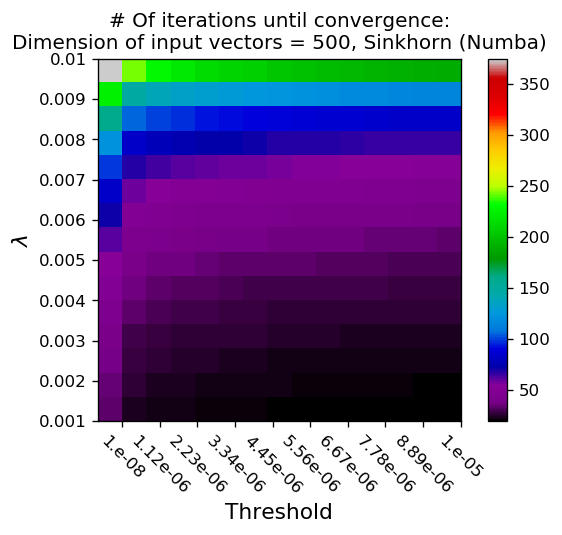

In [26]:
params_a = [-0.5,2,-1,0.5]
params_b = [0.5,6,-1,0.5]
dim = 500
exponent = 2
xa = np.linspace(-2,2,dim)
xb = np.linspace(-2,2,dim)
nvec_a = normalized_function(xa,funct2,params_a)
nvec_b = normalized_function(xb,funct2,params_b)
M = cost_matrix(nvec_a,nvec_b)
M /= M.max()
points = 15
lambds = np.linspace(1e-3,1e-2,points)
thresholds = np.linspace(1e-8,1e-5,points)
err_check = 1
iters = []
for lambd in lambds:
    cache = []
    for threshold in thresholds:
        data = Sinkhorn(nvec_a,nvec_b, M,lambd = lambd,threshold = threshold, err_check = err_check)
        cache.append(len(data[2]))
    iters.append(copy.deepcopy(cache))
iters = np.array(iters)
vis_mat(iters, ranges = [thresholds[0],thresholds[-1],lambds[0],lambds[-1]], plot = False)
plt.title('# Of iterations until convergence:\nDimension of input vectors = ' + str(dim) + ', Sinkhorn (Numba)')
plt.ylabel('$\lambda$')
plt.xlabel('Threshold')
plt.show()

__Observation:__ We find that both increasing $\lambda$ and the __threshold__ both increase the number of iterations required for convergence.

## Effect dimension of input vectors on convergence

We now do the same thing for the size of the input vectors.

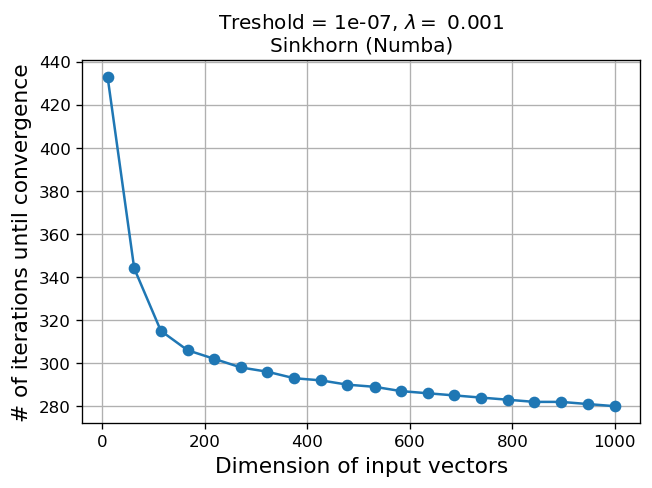

In [27]:
params_a = [-0.5,2,-1,0.5]
params_b = [0.5,6,-1,0.5]
dims = np.linspace(10,1000,20)
dims = [int(dim) for dim in dims]
exponent = 2
lambd = 1e-3
threshold = 1e-7
err_check = 1
iters = []
for dim in dims: 
    
    xa = np.linspace(-2,2,dim)
    xb = np.linspace(-2,2,dim)
    nvec_a = normalized_function(xa,funct2,params_a)
    nvec_b = normalized_function(xb,funct2,params_b)
    M = cost_matrix(nvec_a,nvec_b)
    M /= M.max()
    data = Sinkhorn(nvec_a,nvec_b, M,lambd = lambd,threshold = threshold, err_check = err_check)
    data = len(data[2])
    iters.append(data)
    
plt.plot(dims,iters,marker = 'o')
plt.title('Treshold = ' + str(threshold) + ', $\lambda =$ ' + str(lambd)+ '\nSinkhorn (Numba)')
plt.xlabel('Dimension of input vectors')
plt.ylabel('# of iterations until convergence')
plt.grid(True)
plt.show()

__Observation:__ We find the number of iterations required for convergence decreases when the input vectors are of larger dimension.

## Different input vectors

Finally, we experiment with three types of inputs, namely:

- $\mathbf{a}$ and $\mathbf{b}$ containing only values greater than zero

- $\mathbf{a}$ and $\mathbf{b}$ containing only positive values including zeros

- $\mathbf{a}$ and $\mathbf{b}$ containing both negative and positive values

all properly normalized. The first two cases should not give any problems. However, the final case should not give sensible solutions for either of the algorithms.

Input dimension: 30
λ = 0.01
Threshold = 1e-07


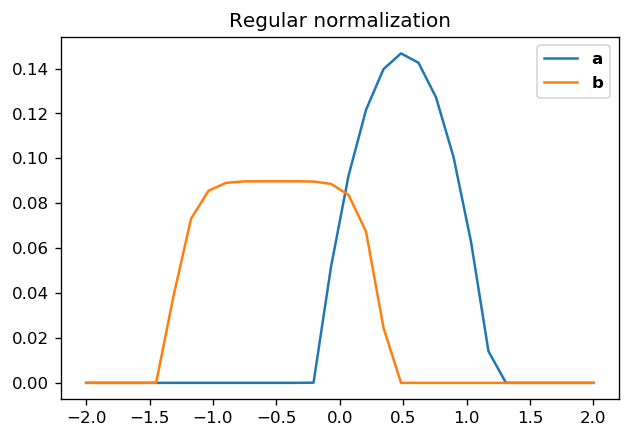

Surface a: 1.0
Surface b: 1.0
a: [1.46734784e-05 1.46734784e-05 1.46734784e-05 1.46734784e-05
 1.46734784e-05 1.46734784e-05 1.46734784e-05 1.46734784e-05
 1.46734784e-05 1.46734784e-05 1.46734784e-05 1.46734784e-05
 1.46734784e-05 1.01963654e-04 5.17777473e-02 9.22803886e-02
 1.21609887e-01 1.39766244e-01 1.46749458e-01 1.42559529e-01
 1.27196459e-01 1.00660245e-01 6.29508898e-02 1.40683917e-02
 1.46734784e-05 1.46734784e-05 1.46734784e-05 1.46734784e-05
 1.46734784e-05 1.46734784e-05]
b: [8.97817180e-06 8.97817180e-06 8.97817180e-06 8.97817180e-06
 8.97817180e-06 3.89470025e-02 7.31933907e-02 8.56044948e-02
 8.90924365e-02 8.97369685e-02 8.97901412e-02 8.97906961e-02
 8.97881894e-02 8.96768434e-02 8.86391271e-02 8.36990652e-02
 6.73852763e-02 2.45037393e-02 8.97817180e-06 8.97817180e-06
 8.97817180e-06 8.97817180e-06 8.97817180e-06 8.97817180e-06
 8.97817180e-06 8.97817180e-06 8.97817180e-06 8.97817180e-06
 8.97817180e-06 8.97817180e-06]

Wasserstein distance Sinkhorn (Numba): 0.2614

/home/toby/anaconda3/lib/python3.7/site-packages/ot/bregman.py:351: RuntimeWarning: divide by zero encountered in true_divide
  Kp = (1 / a).reshape(-1, 1) * K


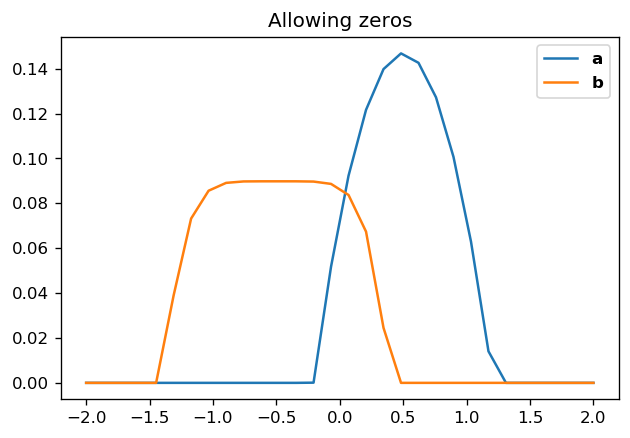

Surface a: 1.0
Surface b: 1.0
a: [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 8.73286176e-05 5.17858702e-02 9.23063488e-02
 1.21648764e-01 1.39813117e-01 1.46799406e-01 1.42607633e-01
 1.27237796e-01 1.00689896e-01 6.29639333e-02 1.40599074e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
b: [0.         0.         0.         0.         0.         0.03894851
 0.07320413 0.08561858 0.08910746 0.08975216 0.08980535 0.08980591
 0.0898034  0.08969202 0.08865403 0.08371263 0.06739445 0.02450136
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]

Wasserstein distance Sinkhorn (Numba): 0.26152695812995935
Wasserstein distance Sinkhorn (POT): 0.027626404635837112
Exact Wasserstein distance (POT): 0.25397945557883794


/home/toby/anaconda3/lib/python3.7/site-packages/ot/lp/__init__.py:113: UserWarning: Problem infeasible. Check that a and b are in the simplex
  result_code_string = check_result(result_code)


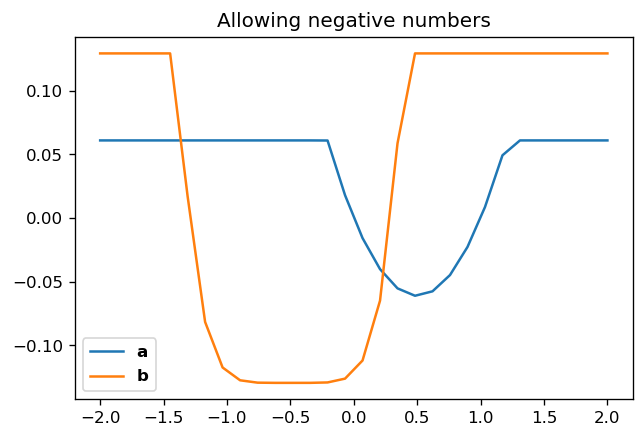

Surface a: 1.0000000000000002
Surface b: 0.9999999999999998
a: [ 0.06103491  0.06103491  0.06103491  0.06103491  0.06103491  0.06103491
  0.06103491  0.06103491  0.06103491  0.06103491  0.06103491  0.06103491
  0.06103491  0.06096233  0.0179984  -0.01567603 -0.04006096 -0.0551564
 -0.06096233 -0.05747877 -0.04470571 -0.02264315  0.0087089   0.04935046
  0.06103491  0.06103491  0.06103491  0.06103491  0.06103491  0.06103491]
b: [ 0.12937029  0.12937029  0.12937029  0.12937029  0.12937029  0.01715538
 -0.08153877 -0.11730614 -0.12735799 -0.12921545 -0.12936869 -0.12937029
 -0.12936307 -0.12904218 -0.1260516  -0.11181491 -0.06480045  0.05877921
  0.12937029  0.12937029  0.12937029  0.12937029  0.12937029  0.12937029
  0.12937029  0.12937029  0.12937029  0.12937029  0.12937029  0.12937029]

Wasserstein distance Sinkhorn (Numba): nan
Wasserstein distance Sinkhorn (POT): 0.08058148961917107
Exact Wasserstein distance (POT): 0.0


In [28]:
def funct3(x, params):
    array = params[2]*(x+params[0])**params[1] + params[3]
    return np.array([max(0,i) for i in array]) - 0.25

exponent = 2
threshold = 1e-7
lambd = 1e-2
maxiters = 100000
params_a = [-0.5,2,-1,0.5]
params_b = [0.5,6,-1,0.5]
dim = 30
print('Input dimension: ' + str(dim) + '\nλ = ' + str(lambd) + '\nThreshold = ' + str(threshold))
xa = np.linspace(-2,2,dim)
xb = np.linspace(-2,2,dim)



M = cost_matrix(xa,xb,exponent = exponent)
M /= M.max()

nvec_a = normalized_function(xa,funct3,params_a)
nvec_b = normalized_function(xb,funct3,params_b)

data = Sinkhorn(nvec_a,nvec_b,M,lambd = lambd,maxiters = maxiters,threshold = threshold)
convergence = data[3]
                
G1 = data[0]       
G2 = ot.sinkhorn(nvec_a, nvec_b, M, lambd, verbose=False, numItermax=maxiters, stopThr=threshold)
G3 = ot.emd(nvec_a,nvec_b,M)
            
plt.plot(xa,nvec_a,label = '$\mathbf{a}$')
plt.plot(xb,nvec_b,label = '$\mathbf{b}$')
plt.legend()
plt.title('Regular normalization')
plt.show()
print('Surface a: ' + str(np.sum(nvec_a)))
print('Surface b: ' + str(np.sum(nvec_b)))
print('a: ' + str(nvec_a))
print('b: ' + str(nvec_b))
print('\nWasserstein distance Sinkhorn (Numba): ' + str(Wasserstein_distance(G1,M)))                 
print('Wasserstein distance Sinkhorn (POT): '+ str(Wasserstein_distance(G2,M)))                
print('Exact Wasserstein distance (POT): '+str(Wasserstein_distance(G3,M)))

nvec_a = normalized_function(xa,funct3,params_a,offset1 = False)
nvec_b = normalized_function(xb,funct3,params_b,offset1 = False)

data = Sinkhorn(nvec_a,nvec_b,M,lambd = lambd,maxiters = maxiters,threshold = threshold)
convergence = data[3]
                
G1 = data[0]            
G2 = ot.sinkhorn(nvec_a, nvec_b, M, lambd, verbose=False, numItermax=maxiters, stopThr=threshold)
G3 = ot.emd(nvec_a,nvec_b,M)
            
plt.plot(xa,nvec_a,label = '$\mathbf{a}$')
plt.plot(xb,nvec_b,label = '$\mathbf{b}$')
plt.legend()
plt.title('Allowing zeros')
plt.show()
print('Surface a: ' + str(np.sum(nvec_a)))
print('Surface b: ' + str(np.sum(nvec_b)))
print('a: ' + str(nvec_a))
print('b: ' + str(nvec_b))
print('\nWasserstein distance Sinkhorn (Numba): ' + str(Wasserstein_distance(G1,M)))                 
print('Wasserstein distance Sinkhorn (POT): '+ str(Wasserstein_distance(G2,M)))                 
print('Exact Wasserstein distance (POT): '+str(Wasserstein_distance(G3,M)))

nvec_a = normalized_function(xa,funct3,params_a,offset = False,offset1 = False)
nvec_b = normalized_function(xb,funct3,params_b,offset = False, offset1 = False)

data = Sinkhorn(nvec_a,nvec_b,M,lambd = lambd,maxiters = maxiters,threshold = threshold)
convergence = data[3]
                
G1 = data[0]            
G2 = ot.sinkhorn(nvec_a, nvec_b, M, lambd, verbose=False, numItermax=maxiters, stopThr=threshold)
G3 = ot.emd(nvec_a,nvec_b,M)
            
plt.plot(xa,nvec_a,label = '$\mathbf{a}$')
plt.plot(xb,nvec_b,label = '$\mathbf{b}$')
plt.legend()
plt.title('Allowing negative numbers')
plt.show()
print('Surface a: ' + str(np.sum(nvec_a)))
print('Surface b: ' + str(np.sum(nvec_b)))
print('a: ' + str(nvec_a))
print('b: ' + str(nvec_b))
print('\nWasserstein distance Sinkhorn (Numba): ' + str(Wasserstein_distance(G1,M)))                 
print('Wasserstein distance Sinkhorn (POT): '+ str(Wasserstein_distance(G2,M)))                
print('Exact Wasserstein distance (POT): '+str(Wasserstein_distance(G3,M)))

__Obervation:__ We find that in the first case the resulting $W_2$ values are quite similar for each of the algorithms. In the second case however, we find that the POT implementation of the algorithm gives a deviating result. This is most likely cause by the face that in their implementation the following is done: 

$$f_i^{n+1} = \frac{1}{\frac{1}{a_i}(\mathbf{K}\mathbf{g}^{n+1})_i},$$

resulting in infinities at the positions where $\mathbf{a}$ contains zeros (https://github.com/rflamary/POT/blob/master/ot/bregman.py - sinkhorn_knopp function). In the final case, all of the algorithms give strange outcomes. This was to be expected, since for negative values in $\mathbf{a}$ and $\mathbf{b}$ the constraints

$$\sum_{ij} \gamma_{ij} = 1,\\ \gamma_{ij} \geq 0\text{, } \forall i,j \text{ }, \\ \sum_i \gamma_{ij} = b_j,\\ \sum_j \gamma_{ij} = a_i.$$

can no longer be satisfied, because the second constraint and the last two constraints now results in a contradiction. This is also likely to be a contributor to the small difference in obtained $W_2^\lambda$ between our implementation and the POT implementation.